In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab Notebooks

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# fix randomness
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2

# Import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import preprocess_input function from EFFICIENTNET_V2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Import other libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Data loading

In [ ]:
leaves = np.load('public_data.npz', allow_pickle=True)

# storing the data
# features (training set + validation set + test set)
X_tmp = leaves['data']
# labels (training set + validation set + test set)
y_categorical = leaves['labels']

labels = {0: 'healthy', 1:'unhealthy'}

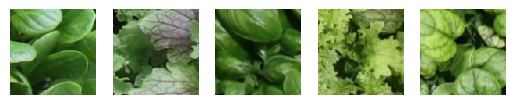

In [ ]:
# Display 5 images
num_samples = 5
# randomly select 5 pics to display with no replications
sample_indices = np.random.choice(len(X_tmp), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)

    # Normalize the image data to the range [0, 1]
    normalized_image = X_tmp[idx] / 255.0  # If your original pixel values are in [0, 255]

    plt.imshow(normalized_image)
    plt.axis('off')

plt.show()

### Data pre-processing

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical data
y_tmp = label_encoder.fit_transform(y_categorical)

# print(y_train_val)
print(pd.Series(y_tmp).value_counts())
print("-------")
print(y_tmp.shape)
# healthy -> 0
# unhealthy -> 1

0    3199
1    2001
dtype: int64
-------
(5200,)


### Outliers Removal

In [ ]:
# outlier detection function
def outlier(x):
    return (np.all(x==X_tmp[58]) or np.all(x==X_tmp[412]))

# Identify non-outlier indices
non_outlier_indices = ~np.array([outlier(x) for x in X_tmp])

outlier_indices = np.array([outlier(x) for x in X_tmp])

outliers = X_tmp[outlier_indices]

# Create X and y arrays without outliers
X_default = X_tmp[non_outlier_indices]
y_default = y_tmp[non_outlier_indices]

# Print the result
# print("X:", X)
# print("y:", y)

In [ ]:
X_default.shape

(5004, 96, 96, 3)

In [ ]:
y_default.shape

(5004,)

In [ ]:
outliers.shape

(196, 96, 96, 3)

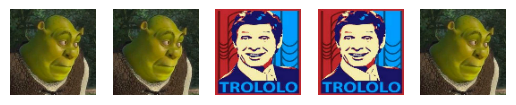

In [ ]:
# Display 5 images
num_samples = 5
# randomly select 5 pics to display with no replications
sample_indices = np.random.choice(len(outliers), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)

    # Normalize the image data to the range [0, 1]
    normalized_image = outliers[idx] / 255.0  # If your original pixel values are in [0, 255]

    plt.imshow(normalized_image)
    plt.axis('off')

plt.show()

In [ ]:
# print(y_train_val)
print(pd.Series(y_default).value_counts())

0    3101
1    1903
dtype: int64


In [ ]:
X = X_default
y = y_default

### Data splitting

In [ ]:
# Normalizing data
X = (X / 255).astype('float32')

In [ ]:
# Random splitting Train Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state=seed, shuffle = True )
print(f"Train, Val, Test randomly split !")

Train, Val, Test randomly split !


In [ ]:
preprocessing = tfk.Sequential([
    tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
    #tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
    #tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop'),
    tfkl.RandomZoom(0.2),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2)
], name = 'preprocessing')

In [ ]:
# Generate new unhealthy images and put in training set
unique, counts = np.unique(y_train, return_counts=True)
label_difference = abs(counts[0]-counts[1])

unhealthy_indices = np.where(y_train == 1)[0]


selected_indices = np.random.choice(unhealthy_indices, label_difference, replace=False)
selected_images = X_train[selected_indices]
additional_unhealthy = np.full(label_difference, 1)


processed_images = np.array([preprocessing(image).numpy() for image in selected_images])

X_train = np.concatenate((X_train, processed_images), axis=0)
y_train = np.concatenate((y_train, additional_unhealthy), axis=0)


In [ ]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4452, 96, 96, 3), y_train shape: (4452,)
X_val shape: (401, 96, 96, 3), y_val shape: (401,)
X_test shape: (1001, 96, 96, 3), y_test shape: (1001,)


In [ ]:
print(f"train: \n{pd.Series(y_train).value_counts()}")
print(f"validation: \n{pd.Series(y_val).value_counts()}")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
0    2226
1    2226
dtype: int64
validation: 
0    267
1    134
dtype: int64
test: 
0    608
1    393
dtype: int64


In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))


### Dataset concatenating

In [ ]:
#X_train = np.concatenate((X_train,X_test))
#y_train = np.concatenate((y_train,y_test))

### Hyperparameters setting

In [ ]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 64
epochs = 500
learning_rate = 1e-5
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 64, Epochs: 500, Learning Rate: 1e-05
Input Shape: (96, 96, 3), Output Shape: 2


In [ ]:
metrics = ['accuracy']

In [ ]:
# Pre-processing of input data is included in the EfficientNet
# EfficientNetV2 models expect their inputs to be float tensors
# of pixels with values in the [0-255] range

### Model Cancellation

In [ ]:
del model

### Base line


In [ ]:
model = tfk.Sequential()

# Input layer
model.add(tfkl.Input(shape=(96, 96, 3), name='Input'))  # Changed input shape to (96, 96, 3)

# Convolution + Pooling
model.add(tfkl.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed)
))
model.add(tfkl.BatchNormalization())
model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))

model.add(tfkl.Conv2D(
    filters=256,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed)
))
model.add(tfkl.BatchNormalization())
model.add(tfkl.MaxPooling2D(pool_size=(3, 3)))

model.add(tfkl.Conv2D(
    filters=512,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed)
))
model.add(tfkl.BatchNormalization())
model.add(tfkl.MaxPooling2D(pool_size=(3, 3)))

# Global average pooling
model.add(tfkl.Flatten(name='Flatten'))

# Dropout layer
model.add(tfkl.Dropout(0.4, seed=seed))

# Linear layer with ReLU activation
model.add(tfkl.Dense(
    units=64,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed)
))

# Dropout layer
model.add(tfkl.Dropout(0.4, seed=seed))

# Output layer
model.add(tfkl.Dense(
    units=2,
    activation='softmax',
    kernel_initializer=tfk.initializers.GlorotUniform(seed),
    name='Output'
))

# Compile the model (add this if you are ready to train)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### Hybrid Model

In [ ]:
modelObj1 = tf.keras.applications.mobilenet.MobileNet(
            # discard the fully connected layer at the end
            include_top=False,
            # retrain the weights
            # weights=None,
            weights="imagenet",
            # we use our input layer
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling=None,


)


supernet = tf.keras.applications.Xception(
            # discard the fully connected layer at the end
            include_top=False,
            # retrain the weights
            # weights=None,
            weights="imagenet",
            # we use our input layer
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling=None,

)





input_layer = tfkl.Input(shape = input_shape)

preprocess_layer = preprocessing(input_layer)

x = tfkl.Resizing(height=96, width=96)(preprocess_layer)

x1 = supernet(x)
x2= modelObj1(x)

concatenated = tfkl.Concatenate()([x1, x2])
#Convert features of shape 'base_model.output_shape[1:]' to vectors
x = tfkl.GlobalAveragePooling2D()(concatenated)


x = tfkl.Dense(
    units = 128,
    activation = 'relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
)(x)

output_layer = (tfkl.Dense(
    units = 2,
    activation = 'softmax',
    name = 'output',
    # Initializer for the kernel weights matrix
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
))(x)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='HybridModel')

In [ ]:
# freeze the layers

N = 40
N1=44
for i, layer in enumerate(model.get_layer('xception').layers[:N]):
  layer.trainable=False

for i, layer in enumerate(model.get_layer('mobilenet_1.00_224').layers[:N1]):
  layer.trainable=False

### Xception

In [ ]:
modelObj1 = tf.keras.applications.mobilenet.MobileNet(
            # discard the fully connected layer at the end
            include_top=False,
            # retrain the weights
            # weights=None,
            weights="imagenet",
            # we use our input layer
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling=None,


)

In [ ]:

from tensorflow.keras.applications.xception import preprocess_input

supernet = tf.keras.applications.Xception(
            # discard the fully connected layer at the end
            include_top=False,
            # retrain the weights
            # weights=None,
            weights="imagenet",
            # we use our input layer
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling=None,





)

input_layer = tfkl.Input(shape = input_shape)

preprocess_layer = preprocessing(input_layer)

x = tfkl.Resizing(height=96, width=96)(preprocess_layer)

x1 = supernet(x)

#Convert features of shape 'base_model.output_shape[1:]' to vectors
x = tfkl.GlobalAveragePooling2D()(x1)


x = tfkl.Dense(
    units = 128,
    activation = 'relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
)(x)

output_layer = (tfkl.Dense(
    units = 2,
    activation = 'softmax',
    name = 'output',
    # Initializer for the kernel weights matrix
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
))(x)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Xception')

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
# freeze the layers
N = 40
for i, layer in enumerate(model.get_layer('xception').layers[:N]):
  layer.trainable=False

### MobileNetV1

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
supernet = tf.keras.applications.mobilenet.MobileNet(
            # discard the fully connected layer at the end
            include_top=False,
            # retrain the weights
            # weights=None,
            weights="imagenet",
            # we use our input layer
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling=None,


)

In [ ]:
input_layer = tfkl.Input(shape = input_shape)

preprocess_layer = preprocessing(input_layer)

x = tfkl.Resizing(height=96, width=96)(preprocess_layer)

x1 = supernet(x)

#Convert features of shape 'base_model.output_shape[1:]' to vectors
x = tfkl.GlobalAveragePooling2D()(x1)


x = tfkl.Dense(
    units = 128,
    activation = 'relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
)(x)


output_layer = (tfkl.Dense(
    units = 2,
    activation = 'softmax',
    name = 'output',
    # Initializer for the kernel weights matrix
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
))(x)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='MobileNetV1')

In [ ]:
# freeze the layers
N1=44
for i, layer in enumerate(model.get_layer('mobilenet_1.00_224').layers[:N1]):
  layer.trainable=False

### Model summary

In [ ]:
model.summary()

Model: "HybridModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (96, 96, 3)               0         
                                                                 
 resizing_1 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 3, 3, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 128)               

In [ ]:
# Defining Parameters
loss = tfk.losses.BinaryCrossentropy()
optimizer = tfk.optimizers.legacy.Adam(learning_rate)
metrics = ['accuracy']

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)


### Model Compilation for Xception and MobileNet

In [ ]:

history = model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    validation_data = (preprocess_input(X_val*255),y_val),
    epochs = 250,
    batch_size=batch_size,
    #animate a bar
    verbose=1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=25, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode="max", patience=25,restore_best_weights=True)]
).history

### Model Compilation for Baseline

In [ ]:

history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val,y_val),
    epochs = 250,
    batch_size=batch_size,
    #animate a bar
    verbose=1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=25, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode="max", patience=25,restore_best_weights=True)]
).history

### Ploting and Save Model

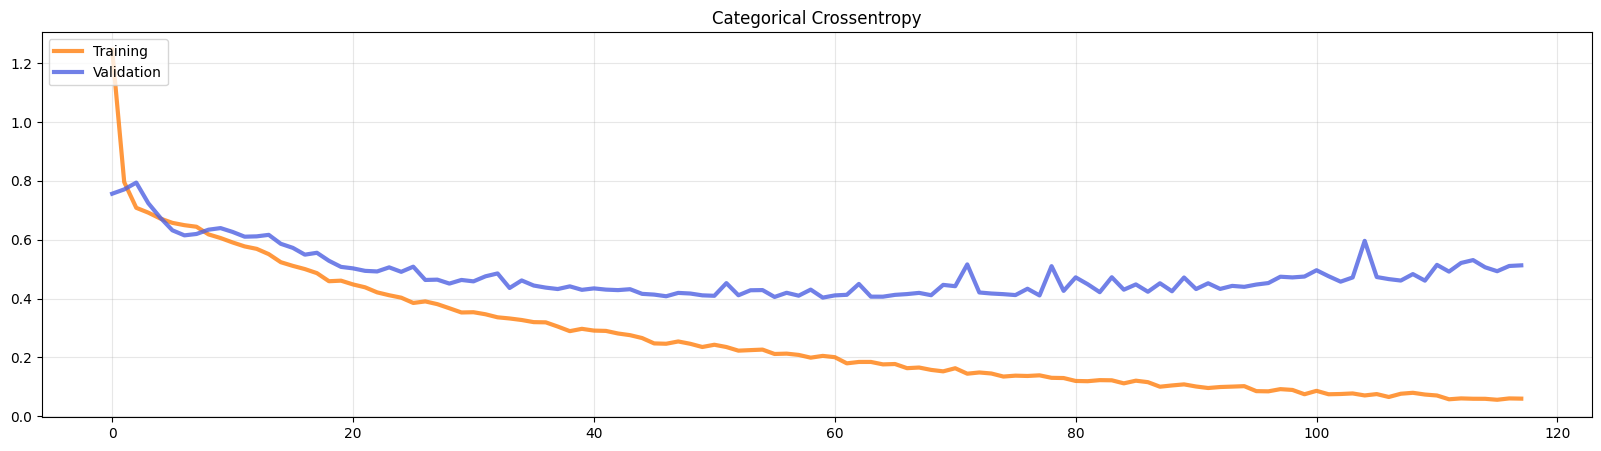

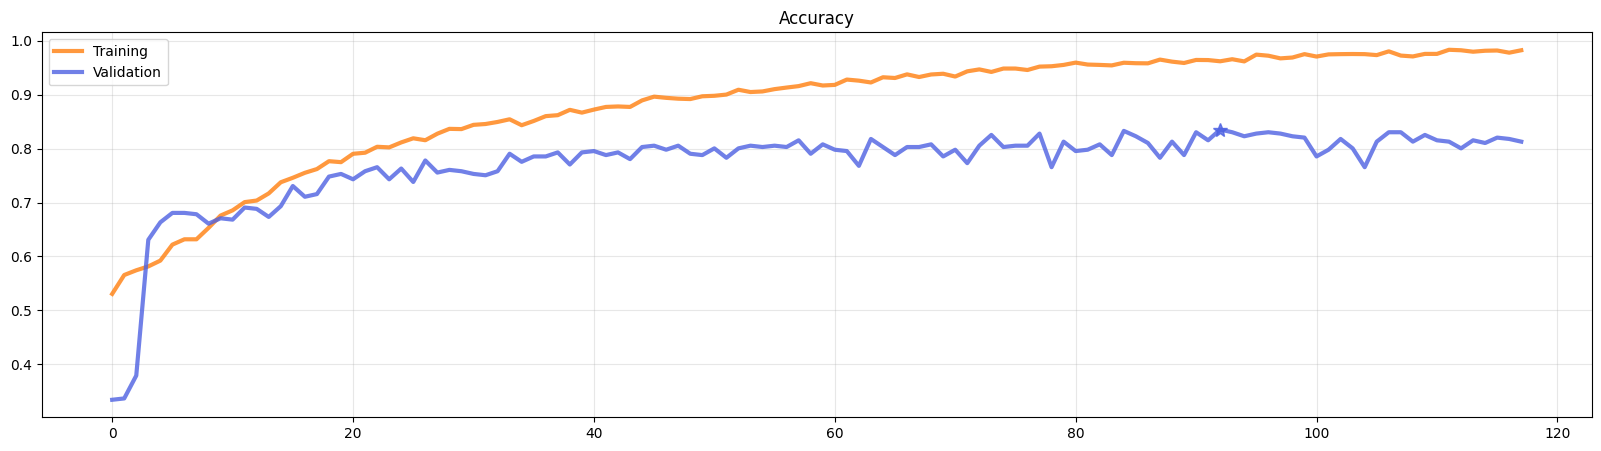

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
model.save("Xception")
del model


### Test Model

In [ ]:
model = tf.keras.models.load_model('Xception')


In [ ]:
# Evaluate on the test set
test_acc = model.evaluate(X_test, y_test, verbose=0)[-1]
print("Test set accuracy is %.4f"% test_acc)

Test set accuracy is 0.7762


In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1001, 2)


Accuracy: 0.7762
Precision: 0.7696
Recall: 0.7533
F1: 0.7588


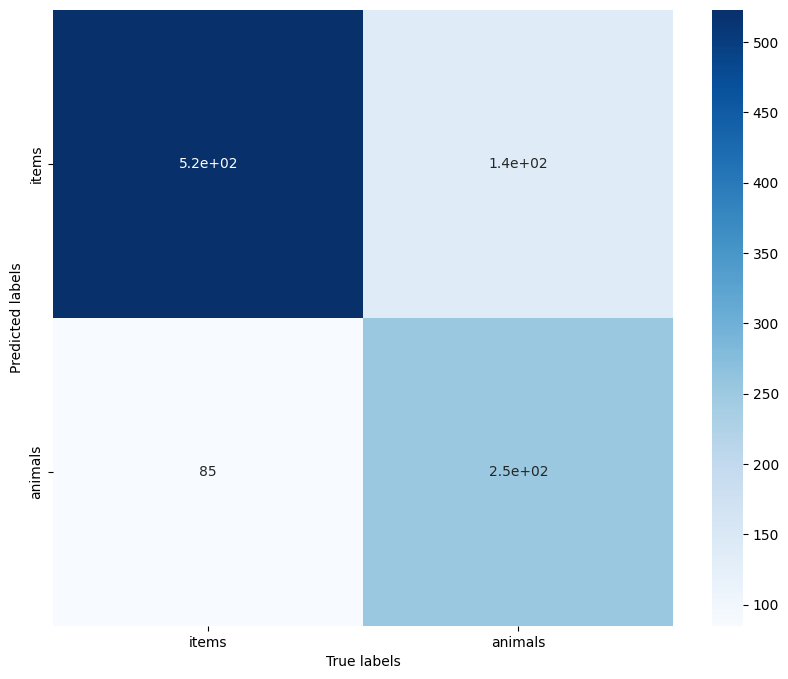

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('items','animals')), yticklabels=list(('items','animals')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Test Time Data Augmentation

In [ ]:
# we are apply the ttda to improve the accuracy

from tqdm.notebook import tqdm_notebook
from tqdm import tqdm


preprocessing = tfk.Sequential([
    tfkl.RandomFlip('horizontal',name='RandomFlip_horizontal'),
    tfkl.RandomFlip('vertical',name='RandomFlip_vertical'),
    #tfkl.RandomBrightness(0.1)
    #tfkl.RandomZoom(0.2),
    #tfkl.RandomTranslation(0.2,0.2),
], name = 'preprocessing')

def predict_prob(X,model):

    out = []

    for idx in tqdm_notebook(range(X.shape[0])):

        x = X[idx]

        images_to_predict = []
        images_to_predict.append(x)

        for i in range(25):
            augment_image = preprocessing(x)
            #augment_image = datagenerator.random_transform(x)
            images_to_predict.append(augment_image)

        images_to_predict = np.array(images_to_predict)
        predictions = model.predict(images_to_predict, verbose=0)
        mean_prediction = np.mean(predictions, axis=0)
        out.append(mean_prediction)

    return tf.stack(out)

In [ ]:
# ttda predict for baseLine
# Predict labels for the entire test set
predictions_ttda = predict_prob(X_test, model)

# Display the shape of the predictions
print("Predictions Shape:", predictions_ttda.shape)

In [ ]:
# Predict labels for the entire test set
predictions_ttda = predict_prob(preprocess_input(X_test*255), model)

# Display the shape of the predictions
print("Predictions Shape:", predictions_ttda.shape)

  0%|          | 0/1001 [00:00<?, ?it/s]

Predictions Shape: (1001, 2)


Accuracy: 0.7782
Precision: 0.7698
Recall: 0.7589
F1: 0.7631


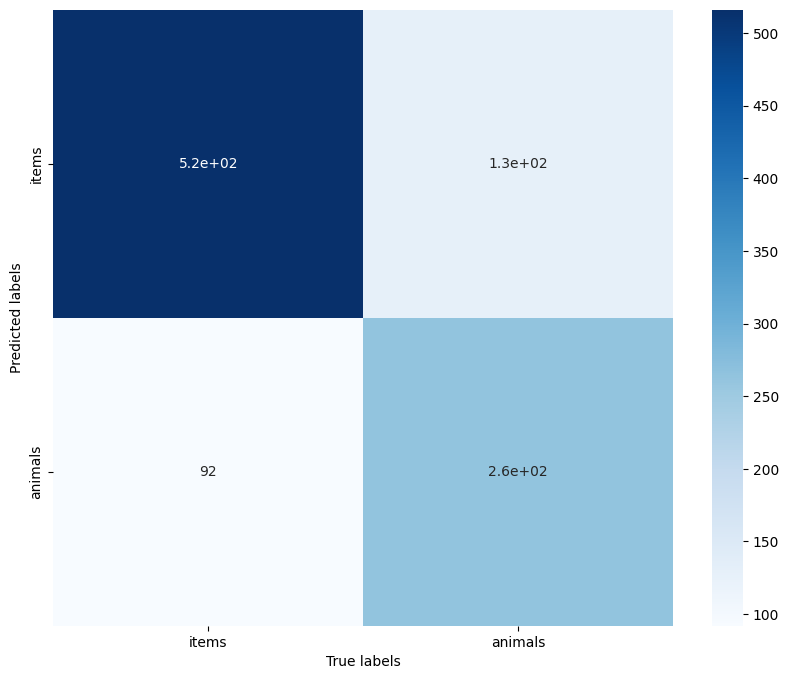

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ttda, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('items','animals')), yticklabels=list(('items','animals')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Visualization of missing data

In [ ]:
def visualize_data(images, categories=None, class_names=None):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(min(3 * 7, len(images))):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        if class_names and categories is not None:
            class_index = categories[i].argmax()
            plt.xlabel(class_names[class_index])
    plt.show()

In [ ]:
#true classes
t = np.argmax(y_test, axis=-1)

#predicted classes
p = np.argmax(predictions_ttda, axis=-1)

#mispredicted indices
miss_indices = np.where(t!=p)
print(miss_indices)

(array([   2,   10,   13,   27,   29,   31,   45,   46,   52,   56,   66,
         68,   72,   74,   84,   89,  100,  103,  105,  108,  112,  116,
        119,  120,  121,  122,  132,  136,  147,  159,  162,  163,  165,
        178,  182,  184,  185,  193,  208,  211,  219,  220,  238,  257,
        266,  275,  276,  277,  279,  301,  308,  309,  311,  317,  320,
        321,  325,  334,  344,  345,  349,  356,  357,  359,  382,  394,
        397,  398,  401,  403,  405,  414,  417,  430,  435,  436,  438,
        449,  451,  453,  460,  478,  487,  491,  492,  497,  499,  502,
        505,  508,  515,  519,  525,  527,  531,  533,  542,  544,  549,
        551,  553,  562,  564,  566,  568,  570,  574,  578,  580,  589,
        594,  597,  613,  614,  624,  629,  649,  655,  659,  661,  670,
        675,  684,  689,  692,  695,  697,  700,  708,  710,  715,  718,
        719,  732,  735,  742,  745,  749,  760,  772,  783,  785,  786,
        794,  797,  800,  808,  844,  862,  867,  

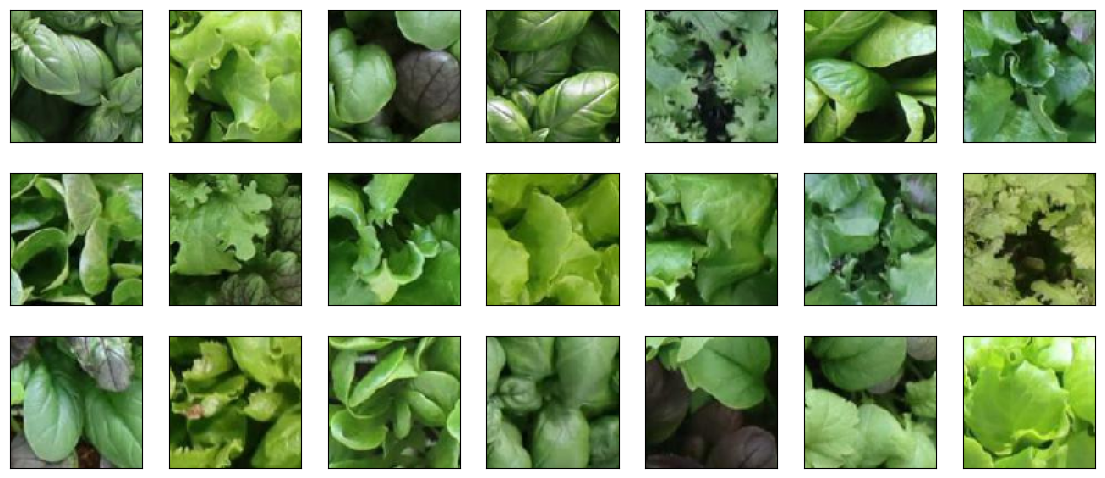

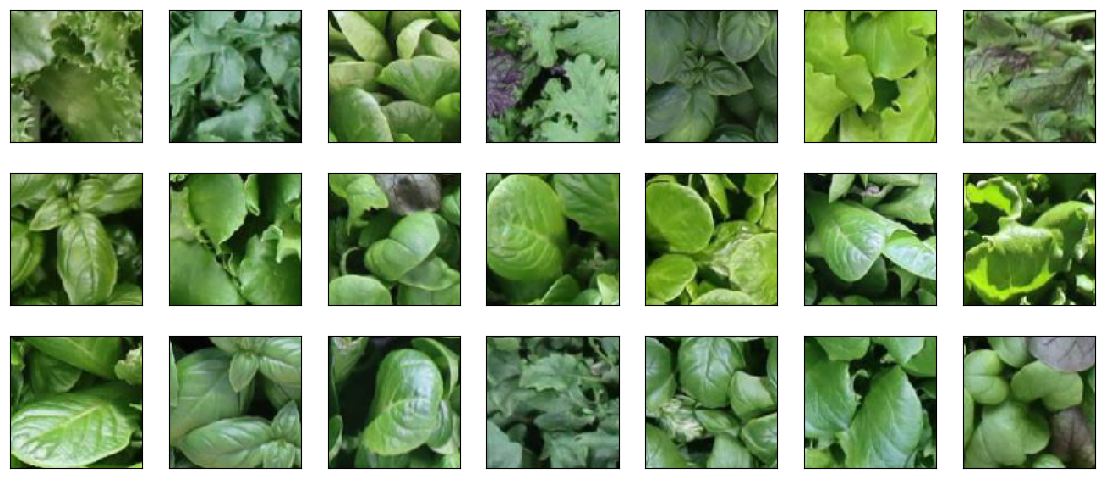

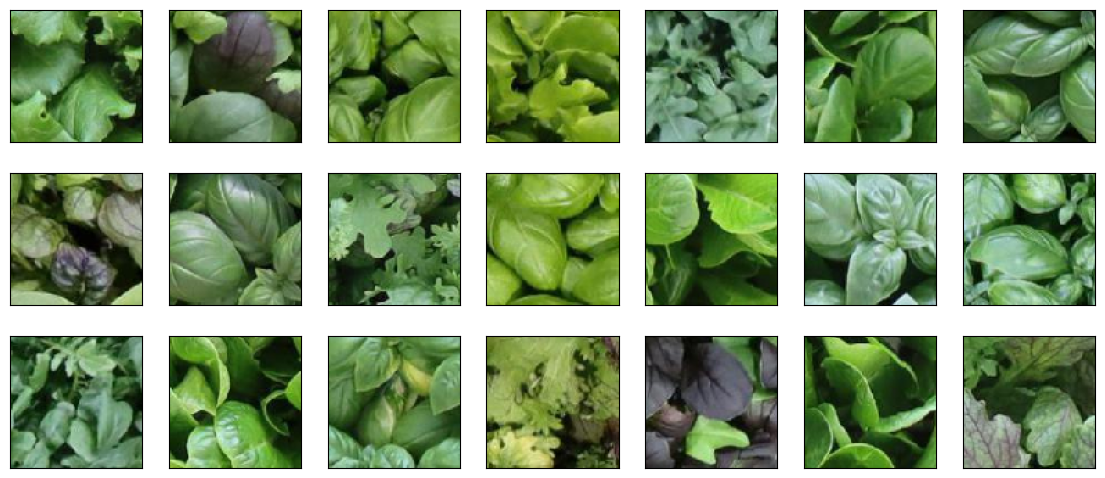

In [ ]:
# visualize mispredicted data
mispred = np.array([x for x in X[miss_indices]])
visualize_data(mispred[(21*1):])
visualize_data(mispred[(21*2):])
visualize_data(mispred[(21*3):])